In [1]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
from glob import glob
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
sys.path.append("..")
from spatial_transform.aff_mnist_data import IMAGE_SIZE, IMAGE_SHAPE, IMAGE_NUM_CHANNELS, get_aff_mnist_data
from spatial_transform.spatial_transforms import AffineTransform, QuadraticTransform
from spatial_transform.st_blocks import SimpleSpatialTransformBlock
from spatial_transform.localization import StandardConvolutionalLocalizationLayer, CoordConvLocalizationLayer, LargeLocalizationLayer
from spatial_transform.interpolation import BilinearInterpolator
from spatial_transform.layers import RepeatWithSharedWeights
from spatial_transform.visualization import show_train_progress

ModuleNotFoundError: No module named 'stn_trail_task.data'

In [4]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

In [ ]:
Image("../images/stn_c0.png")

In [ ]:
image = tf.keras.layers.Input(shape=IMAGE_SHAPE + (IMAGE_NUM_CHANNELS,))
size_after_transform = 28

# first_spatial_transform = AffineTransform()
# first_st_block = SimpleSpatialTransformBlock(
#     localization_layer = CoordConvLocalizationLayer(
#         spatial_transform_params_cls = first_spatial_transform.param_type,
#         init_scale = size_after_transform / IMAGE_SIZE,
#     ),
#     spatial_transform = first_spatial_transform,
#     interpolator = BilinearInterpolator(),
#     shape_out = (size_after_transform, size_after_transform)
# )

spatial_transform = QuadraticTransform()
st_block = SimpleSpatialTransformBlock(
    localization_layer = LargeLocalizationLayer(
        spatial_transform_params_cls = spatial_transform.param_type,
        init_scale = 1,
    ),
    spatial_transform = spatial_transform,
    interpolator = BilinearInterpolator(),
    shape_out = (size_after_transform, size_after_transform)
)
stn_slx_chain = RepeatWithSharedWeights(layer=st_block, num_repetitions=3)




input_shape = (40, 40, 1)
image = tf.keras.layers.Input(shape=input_shape)
size_after_transform = 28




interpolation_layer = BilinearInterpolation(height_out=size_after_transform, width_out=size_after_transform)
stn_slx_block = SimpleSpatialTransformBlock(
    localization_layer = CoordConvLocalizationLayer(num_spatial_transform_params=interpolation_layer.num_spatial_transform_params),
    interpolation_layer = interpolation_layer
)
stn_slx_chain = RepeatWithSharedWeights(layer=stn_slx_block, num_repetitions=3)

x = tf.image.resize(image, size=size_after_transform)
x = stn_slx_chain(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu', padding="valid")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(40, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

In [5]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [6]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 6,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/6
12500/12500 [==============================] - 294s 23ms/step - loss: 0.9929 - accuracy: 0.6912 - val_loss: 0.0601 - val_accuracy: 0.9813
Epoch 2/6
12500/12500 [==============================] - 297s 24ms/step - loss: 0.0513 - accuracy: 0.9841 - val_loss: 0.0400 - val_accuracy: 0.9873
Epoch 3/6
12500/12500 [==============================] - 290s 23ms/step - loss: 0.0332 - accuracy: 0.9896 - val_loss: 0.0363 - val_accuracy: 0.9880
Epoch 4/6
12500/12500 [==============================] - 278s 22ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.0268 - val_accuracy: 0.9915
Epoch 5/6
12500/12500 [==============================] - 280s 22ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0259 - val_accuracy: 0.9918
Epoch 6/6
12500/12500 [==============================] - 271s 22ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0279 - val_accuracy: 0.9914


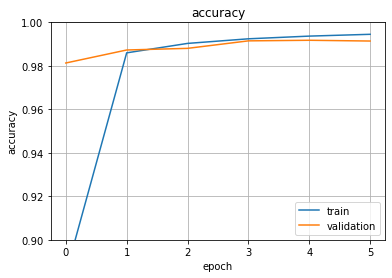

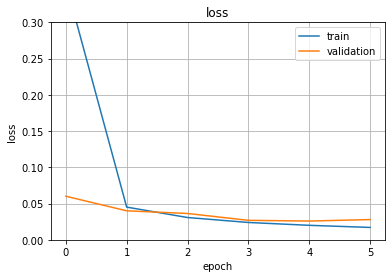

In [7]:
show_train_progress(history)